In this notebook the idea is to load a certain list of images from a folder and then calculate the quality index for each individual slice and plotting them. The last step would be to obtain a criterion to decide whether an image is in focus or not thus obtaining the object height. 

The first cell just obtain the images names from a specified folder:


In [7]:
import os
import re
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.fft import fft, ifft
import numpy as np
from numpy import diff
import cmath
import cv2
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
import time
from scipy.signal import argrelextrema
from natsort import natsorted, ns
from tifffile import imwrite
from PIL import Image
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
import numpy as np
import imageio as iio
import matplotlib.image as mpimg
from matplotlib import cm
from skimage.io import imread, imshow
import cv2
from skimage.transform import hough_line, hough_line_peaks


#List all images in the directory
""" p = r'C:\\Users\\ArzinaIsmaili\\OneDrive - Adaptix Limited\\Desktop\\deconvolution_adaptix2024\\HeightRecogCode\\DowtyPrismBlade2ndHalf'

images = Path(p)
dir_list = os.listdir(images)

ext = '.tif'
res = []

for item in dir_list:
    if bool(re.findall(ext,item)):
        res.append(item)
   
res = natsorted(res, key=lambda y: y.lower())      
print(res)

 """


" p = r'C:\\Users\\ArzinaIsmaili\\OneDrive - Adaptix Limited\\Desktop\\deconvolution_adaptix2024\\HeightRecogCode\\DowtyPrismBlade2ndHalf'\n\nimages = Path(p)\ndir_list = os.listdir(images)\n\next = '.tif'\nres = []\n\nfor item in dir_list:\n    if bool(re.findall(ext,item)):\n        res.append(item)\n   \nres = natsorted(res, key=lambda y: y.lower())      \nprint(res)\n\n "

2


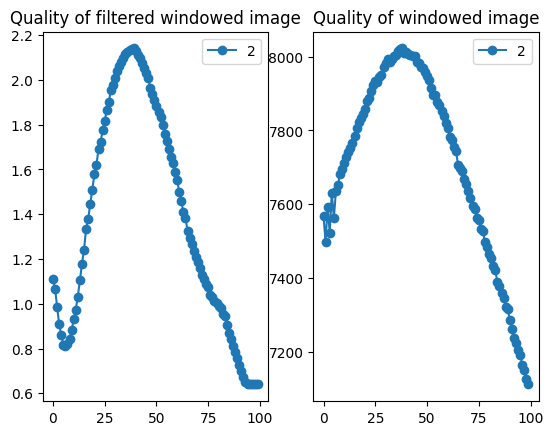

In [18]:
quality = np.empty(1)
quality_data = dict()
quality_img = np.empty(1)
quality_img_data = dict()
fig, ax = plt.subplots(nrows=1, ncols=2)


for thr in range(2,3,1):
    i = 0
    print(thr)
    quality = np.empty(1)
    quality_img = np.empty(1)
    
   
    for item in res:

        start = time.time()
        path = p+'/'+item
        img = imread(path)

        # applying a bandpass filter
        filtered_image = difference_of_gaussians(img, thr)

        # window image to improve FFT (because windowing will reduce discontinuities/spectral leakage)
        wimage = img * window('hann', img.shape)  
        filtered_wimage = filtered_image * window('hann', img.shape)

        # using fftshift so that we are shifting the zero-frequency component to the center of the array
        im_f_mag = fftshift(np.abs(fftn(wimage))) # compute FFT of the original image, not needed during normal usage
        fim_f_mag = fftshift(np.abs(fftn(filtered_wimage))) # compute FFT of the filtered image, also not needed during normal usage
        
        
        save_path = p + r'/Filtered/Fil_'+ item 

        # Create then save an image from the array `filtered_wimage' (stored in the form of a numbered array)
        i = Image.fromarray(filtered_wimage)
        i.save(save_path)
        



        #hole/peak extraction from windowed image
        
        # seed image (a.k.a. marker image) specifies the values that are dilated or eroded
        seed = np.copy(wimage)
        # setting all values (except the outside border) of the seed image to be the max pixel value (255 = white)
        seed[1:-1, 1:-1] = wimage.max() 
        # mask give the maximum (dilation) / minimum (erosion) allowed value at each pixel
        mask = wimage

        # neighbouring high intensity values are replaced by low-intesity values; each seed value must be more than or equal to the 
        # corresponding mask value 
        filled = reconstruction(seed, mask, method='erosion')
   
        seed = np.copy(wimage)
        seed[1:-1, 1:-1] = wimage.min()  # smallest pixel value
        # high-intensity values will replace nearby low-intensity values; each seed value must be less than or equal to the 
        # corresponding mask value; for erosion, the reverse is true
        rec = reconstruction(seed, mask, method='dilation')
        
        peaks = wimage-rec  # this is like subtracting all teh low-intensity pixels, leaving behind the high-intensity ones e.g., edges
        
        save_path = p + r'/Filtered/peaks_'+ item 
        i = Image.fromarray(peaks)
        i.save(save_path)
        
        holes = wimage-filled  # this is like subtracting all the high-intesity pixels, leaving behind the low-intensity ones
        
        save_path = p + r'/Filtered/holes_'+ item 
        i = Image.fromarray(holes)
        i.save(save_path)
        
        #end of hole/peak extraction
        

        non_z_fft = fim_f_mag>0  # boolean 2d array – positive values of the FFT of the filtered image are set to True
        tot = sum(sum(non_z_fft))  # finding the number of True values in the 2D boolean array
        quality = np.append(quality, sum( fim_f_mag[non_z_fft] )/tot)  # the second bit: average all positive values of filtered windowed image

        non_z = img>0  # boolean 2d array - postive values of the original image are set to True
        tot_img = sum(sum(non_z))  # finding the number of True values in the 2D boolean array
        quality_img = np.append(quality_img, sum( wimage[non_z] )/tot_img)  # the second bit: average all positive values of original windowed image
        

        end = time.time()


    quality = quality[1:]  # ignore the first value because its effectively 0
    quality_data[thr] = quality  # quality_data is a dictionary
    
    quality_img = quality_img[1:]
    quality_img_data[thr] = quality_img
    
   
    
    ax[0].plot(quality,'-o',label = '%d' %thr)
    ax[0].legend()
    ax[0].set_title('Quality of filtered windowed image')

    ax[1].plot(quality_img,'-o',label = '%d' %thr)
    ax[1].legend()
    ax[1].set_title('Quality of windowed image')
    

In the following cell, we extract the quality index for each image: the quality index measure how sharp the image is by filtering the image on the low frequencies, extracting the edges

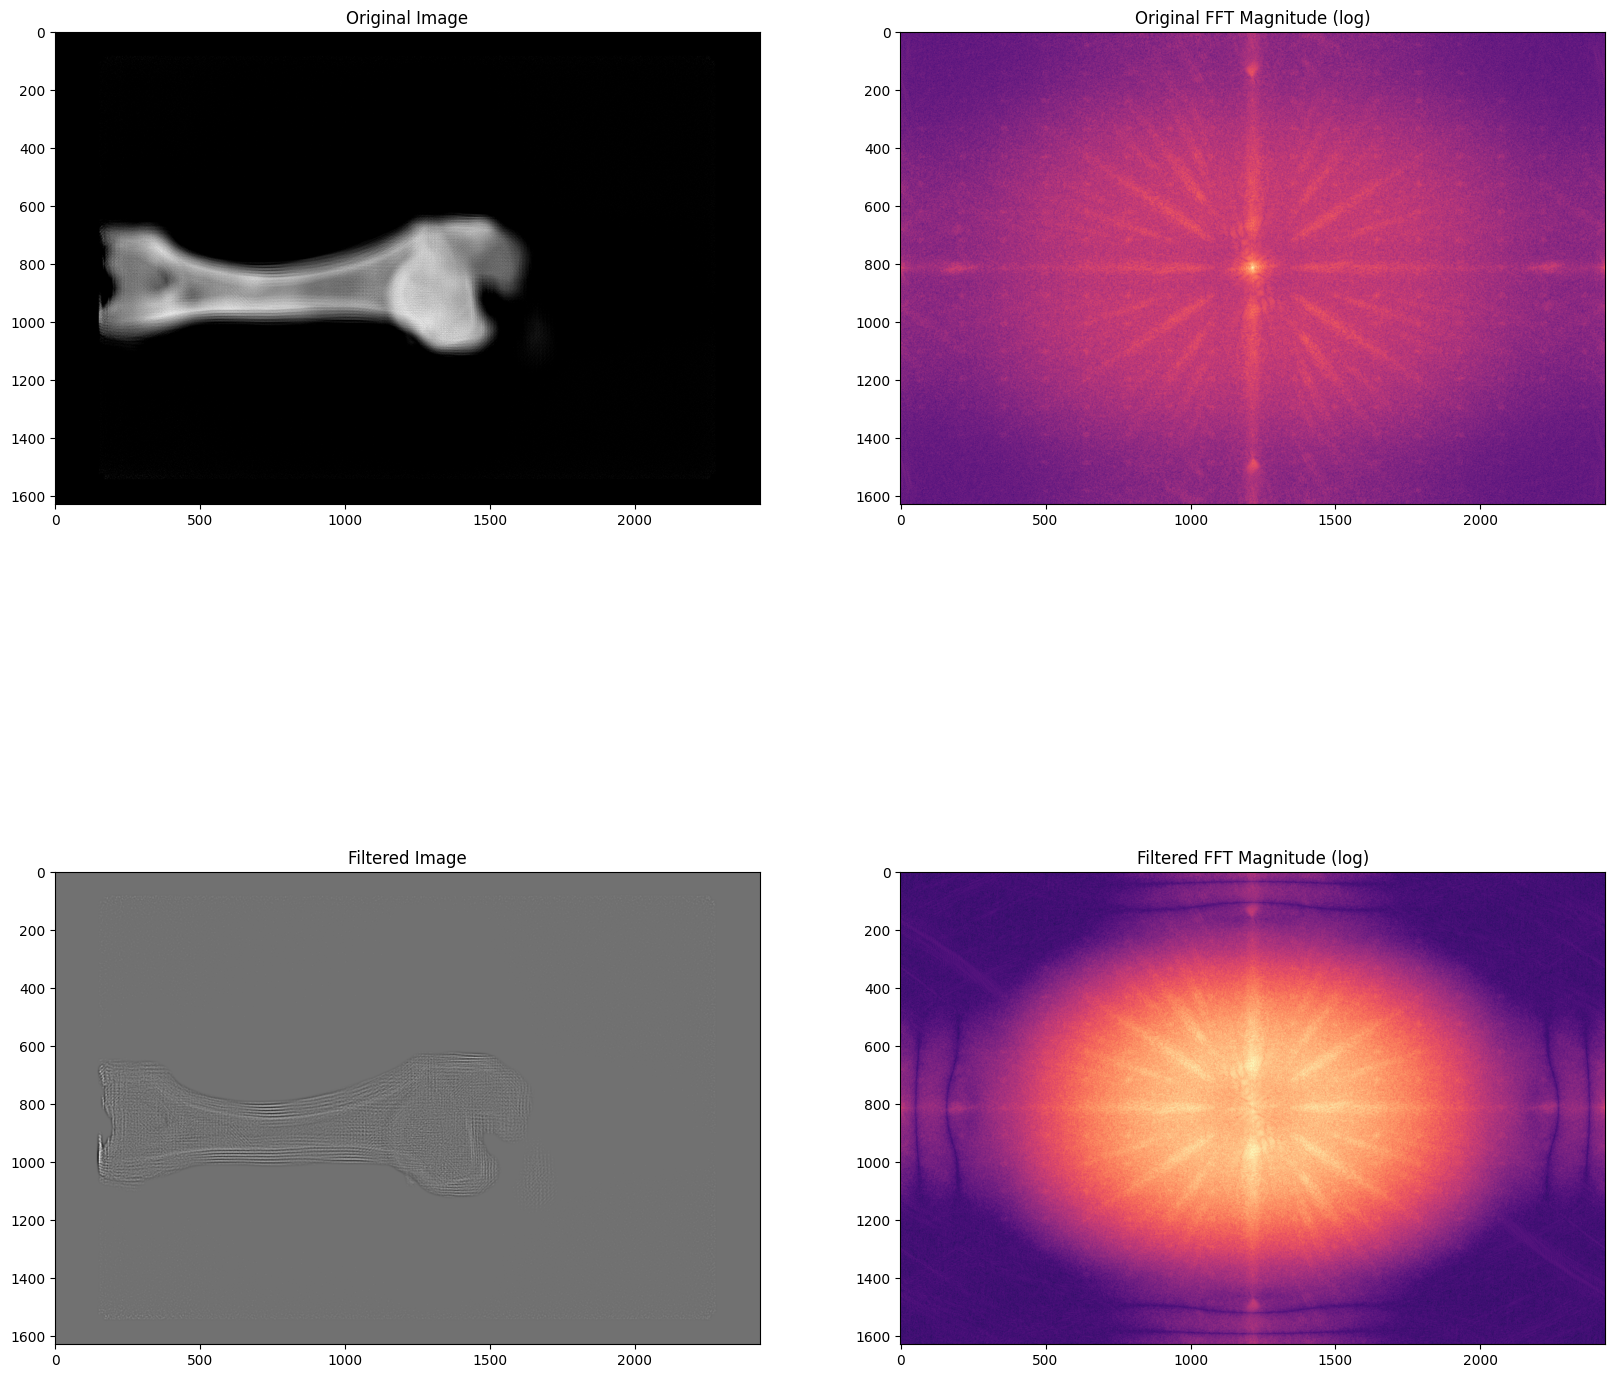

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')

ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')  # bandpass filter using difference of gaussians

ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')

plt.show()

This is a first attempt at extracting peak/holes from our image. It should make spotting faults much easier.

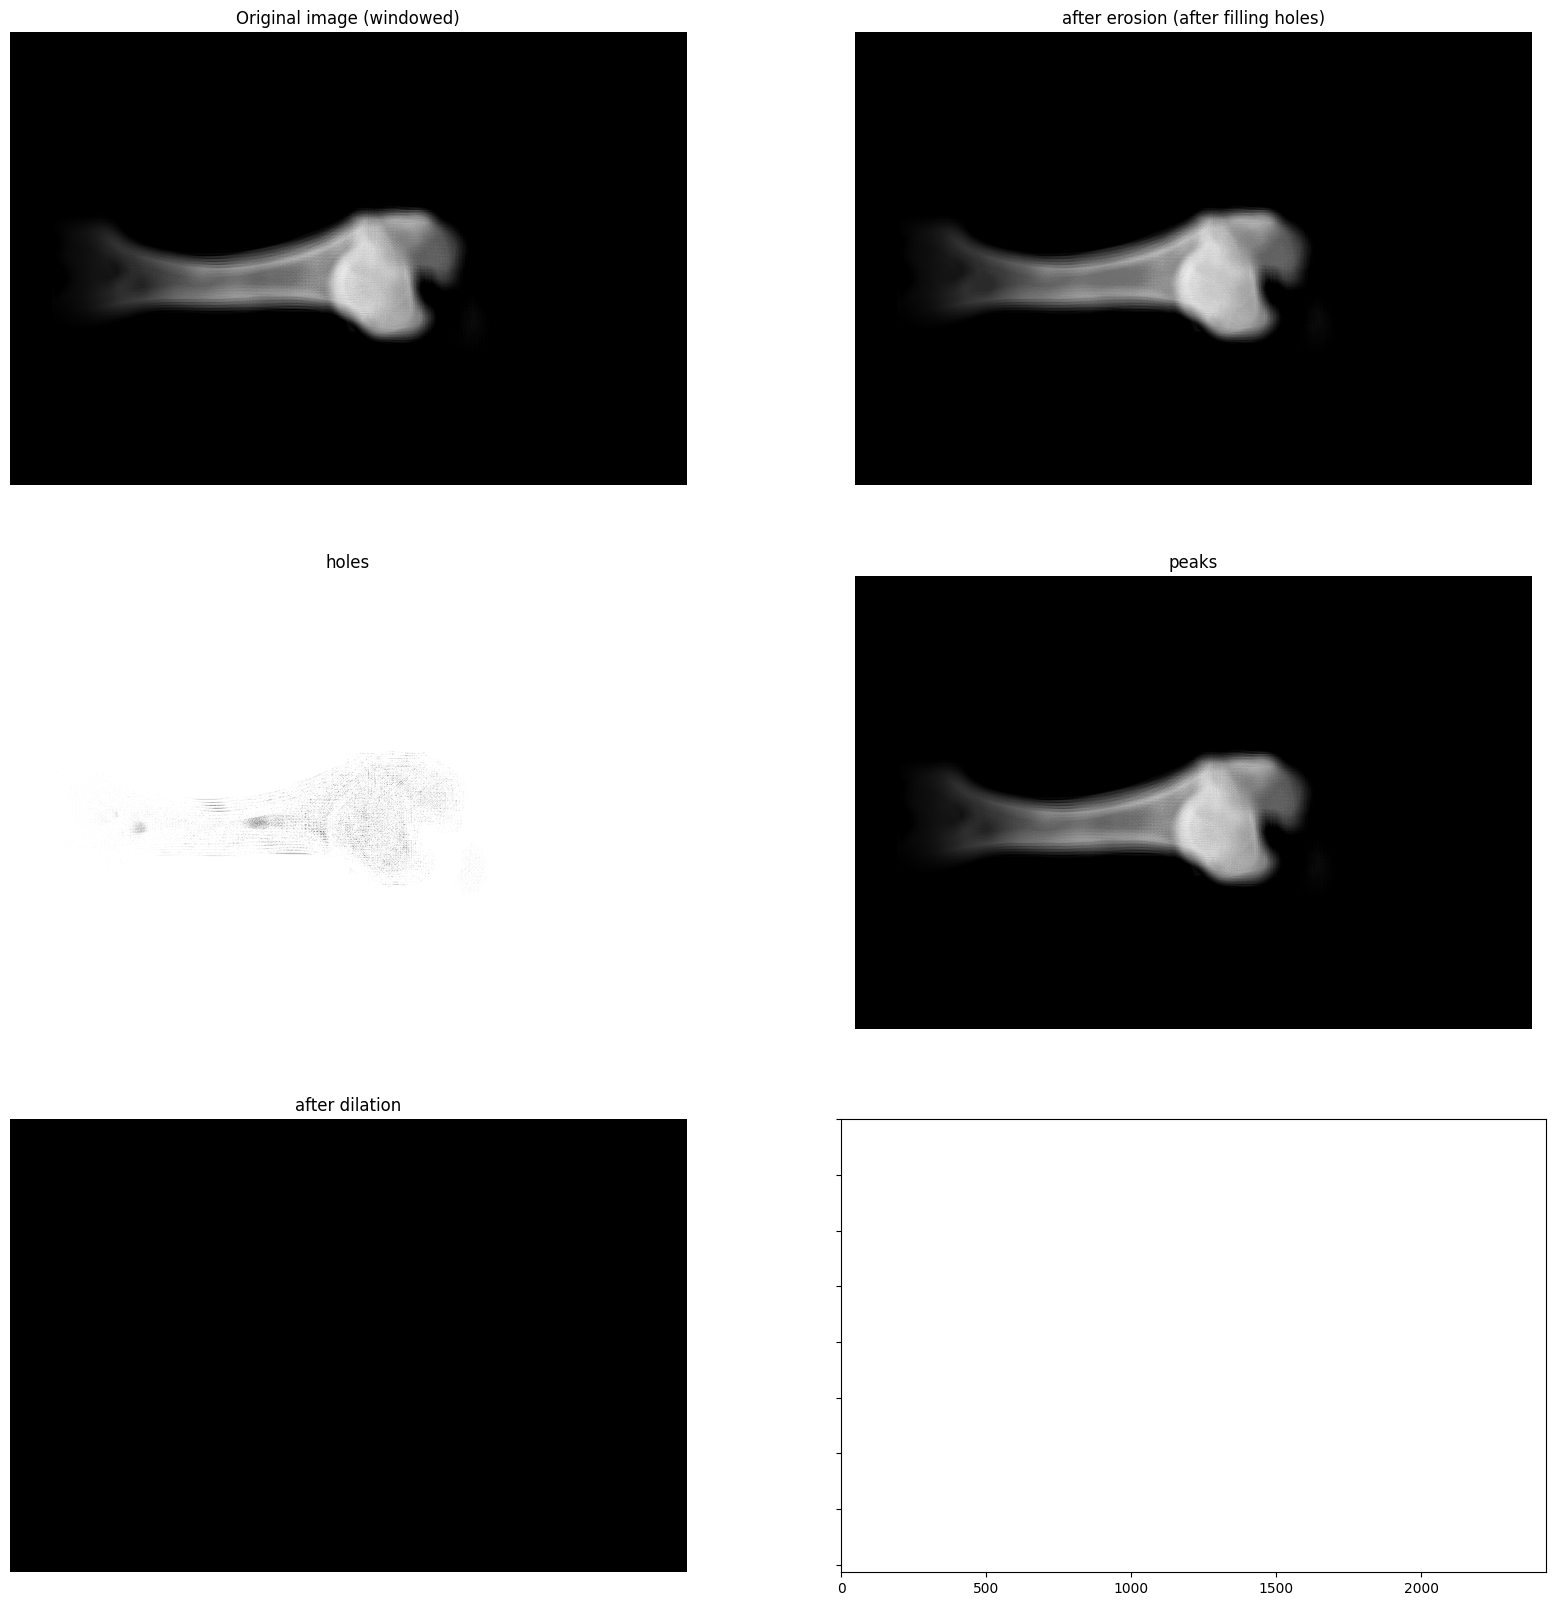

In [23]:

# Confused by what is low/high intensity - i would think its 0/255 black/white, but the images below indicate that low = white, high = black,


# check if we can extract peak and holes automatically
# the below follows this https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_holes_and_peaks.html


# seed image and mask image represent the maximum and minimum possible values of the reconstructed image
seed = np.copy(wimage)
seed[1:-1, 1:-1] = wimage.max()
mask = wimage

# fill holes (i.e. isolated, dark spots) using erosion 
filled = reconstruction(seed, mask, method='erosion')  # neighbouring high intensity (white) values are replaced by low-intesity (blavk) values;


# find bright spots in an image using dilation 
seed = np.copy(wimage)
seed[1:-1, 1:-1] = wimage.min()
rec = reconstruction(seed, mask, method='dilation')  # high-intensity values will replace nearby low-intensity values



fig, ax = plt.subplots(3, 2, figsize=(20, 20), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(wimage, cmap='gray')
ax[0].set_title('Original image (windowed)')
ax[0].axis('off')

ax[1].imshow(filled, cmap='gray')
ax[1].set_title('after erosion (after filling holes)')
ax[1].axis('off')

# we can isolate the dark regions by doing original image – reconstructed/filled image
ax[2].imshow(wimage-filled, cmap='gray')
ax[2].set_title('holes')  # leaving behind all the high-intensity (black) pixels that were covered by erosion?
ax[2].axis('off')

# we can isolate bright regions by doing original image - reconstructed image
ax[3].imshow(wimage-rec, cmap='gray')
ax[3].set_title('peaks')  # this is like subtracting all teh high-intensity pixels, leaving behind the high-intensity ones e.g., edges
ax[3].axis('off')

ax[4].imshow(rec, cmap='gray')
ax[4].set_title('after dilation')
ax[4].axis('off')

plt.show()

#end of peak/hole experiment

In the following section we are trying to fit the image quality index as a gaussian distribution or a sum of gaussian distributions. One approach would be to find local maxima first and then apply a gaussian fit around those points.

[[39]
 [98]]


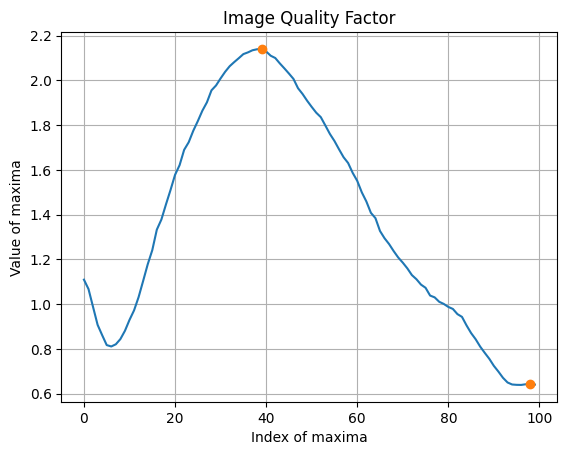

In [24]:
from scipy.signal import argrelextrema  # use to calculate the relative extrema of data

data = quality_data[2]
p = argrelextrema(data, comparator = np.greater, axis = 0, order = 1)  # returns a tuple of nd arrays, containing indices of the maxima in data
# np.greater takes two input arrays (of the same shape), returns a boolean array or scalar  
plt.plot(data,'-')
p = np.transpose(p)
plt.title('Image Quality Factor')
plt.plot(p, data[p],'o')  # plotting index of maxima on x-axis, then maxima value along y-axis
plt.xlabel('Index of maxima')
plt.ylabel('Value of maxima')
plt.grid()
print(p)

p, [[39]
 [98]]
q, [98]
item, 98
x0, 98
x, range(92, 100)
y, [0.67110468 0.6502861  0.64126451 0.63967954 0.63931229 0.64226951
 0.64327173 0.64075767]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

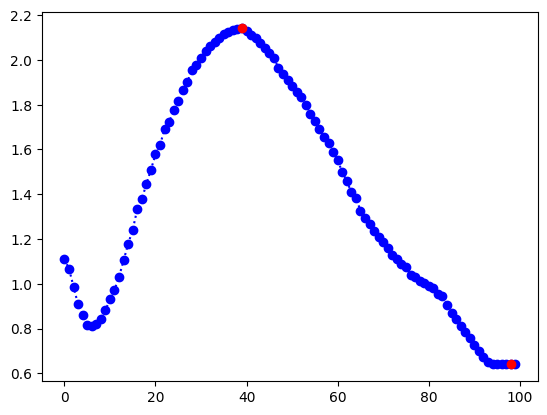

In [31]:
from scipy import stats
from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp
# from numpy import asarray as ar,exp
from scipy.optimize import curve_fit

# same as before
plt.plot(data,'bo:')
p = argrelextrema(data, comparator = np.greater, axis = 0, order = 2)
p = np.transpose(p)
plt.plot(p,data[p],'ro')

print(f'p, {p}')


q = []
for item in p:
    q = item

print(f'q, {q}')

for item in q: 
    
    print(f'item, {item}')
    x0 = int(item)  # x0 is the center
    print(f'x0, {x0}')

    x = range(x0-6, min(100,x0+6)) # pick min between x0+6 and 100 - remove any values greater than max index 100
    print(f'x, {x}')
    y = data[x]
    print(f'y, {y}')

    #Calculating the Gaussian PDF values given Gaussian parameters and random variable X
    def Lorentzian(x, amp1, cen1, wid1):
        # print(f'amp1, {amp1}') set to max(y) later on
        return ( amp1*wid1**2/((x-cen1)**2+wid1**2))  # this isn't guassian and it isnt lorentzian, what is it?
        # x = independent variable
        # all other arguments are parameters to fit

    cen1 = sum(x*y)/sum(y)
    wid1 = sum(y*(x-cen1)**2)/sum(y)
   
    #Gaussian least-square fitting process; 
    # x = independent variable, y = dependent data
    # p0 = initial guess for the parameters
    # popt - Optimal values for the parameters; pcov - estimated approximate covariance of popt
    popt, pcov = curve_fit(Lorentzian,x,y,p0=[max(y),cen1,wid1])
    
    x = range(0,len(data))
    
    # using * here to unpack to array popt
    plt.plot(x,Lorentzian(x,*popt),'r-',label='fit')
    plt.legend()
    print(*popt)

plt.show()




NameError: name 'Lorentzian' is not defined

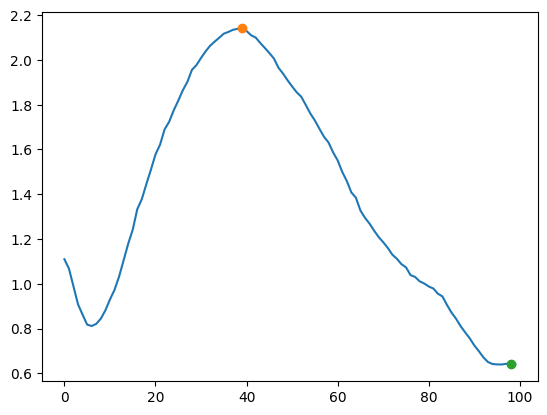

In [30]:

x = range(0,len(data))
plt.plot(data,'-')
p = np.transpose(p)
plt.plot(p,data[p],'o')

plt.plot(x,Lorentzian(x,*popt),'ro:',label='fit')
plt.legend()
plt.show()
print(p)


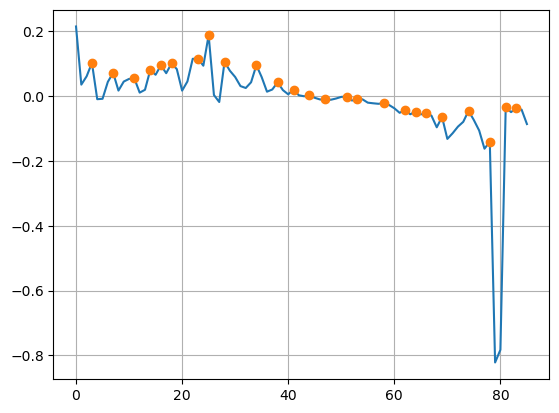

In [15]:
from numpy import diff

dx = 1
dy = np.gradient(data)
p = argrelextrema(dy, np.greater)  # finding indices where there are maxima

p = np.transpose(p)

# print(p)
plt.plot(dy,'-')
plt.plot(p,dy[p],'o')

plt.grid()


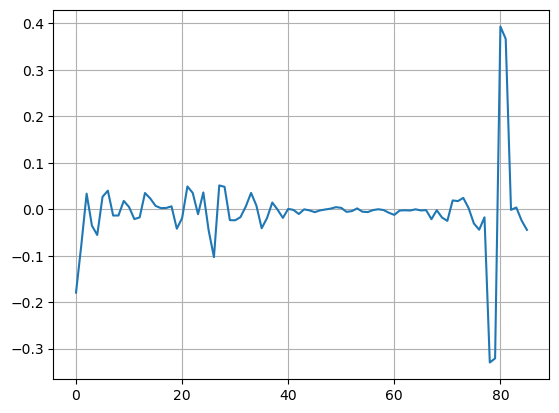

In [17]:
ddy = np.gradient(dy)
plt.plot(ddy,'-')
plt.grid()

We want to crop the image. 
Use image segmentation for this. 
Make each array in the image binary - no object=0 and object=1. 
To find width of object, add up all values in each column with OR. Can do this by adding all rows up with OR, then you have a final array and find the distance between the first col and last col which has 1. 
To find height of object, add all values in each row with OR. Then you are left with a single column - find the index of the first row and last row which has 1.


In [22]:
import os
import re
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.fft import fft, ifft
import numpy as np
from numpy import diff
import cmath
import cv2
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
import time
from scipy.signal import argrelextrema, butter
from natsort import natsorted, ns
from tifffile import imwrite
from PIL import Image
from skimage.morphology import reconstruction
from skimage.exposure import rescale_intensity
import numpy as np
import imageio as iio
import matplotlib.image as mpimg
from matplotlib import cm
from skimage.io import imread, imshow
import cv2
from skimage.transform import hough_line, hough_line_peaks

['1.tiff', '10.tiff', '11.tiff', '12.tiff', '13.tiff', '14.tiff', '15.tiff', '16.tiff', '17.tiff', '18.tiff', '19.tiff', '2.tiff', '20.tiff', '21.tiff', '22.tiff', '23.tiff', '24.tiff', '25.tiff', '26.tiff', '27.tiff', '28.tiff', '29.tiff', '3.tiff', '30.tiff', '31.tiff', '32.tiff', '33.tiff', '34.tiff', '35.tiff', '36.tiff', '37.tiff', '38.tiff', '39.tiff', '4.tiff', '40.tiff', '41.tiff', '42.tiff', '43.tiff', '44.tiff', '45.tiff', '46.tiff', '47.tiff', '48.tiff', '49.tiff', '5.tiff', '50.tiff', '51.tiff', '52.tiff', '53.tiff', '54.tiff', '55.tiff', '56.tiff', '57.tiff', '58.tiff', '59.tiff', '6.tiff', '60.tiff', '61.tiff', '62.tiff', '63.tiff', '64.tiff', '65.tiff', '66.tiff', '67.tiff', '68.tiff', '69.tiff', '7.tiff', '70.tiff', '71.tiff', '72.tiff', '73.tiff', '74.tiff', '75.tiff', '76.tiff', '77.tiff', '78.tiff', '79.tiff', '8.tiff', '80.tiff', '9.tiff', 'keys_file.txt', 'recon_info.txt']
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from th

C:\Users\ArzinaIsmaili\AppData\Local\Temp\ipykernel_14776\2693422552.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))


average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072

KeyboardInterrupt: 

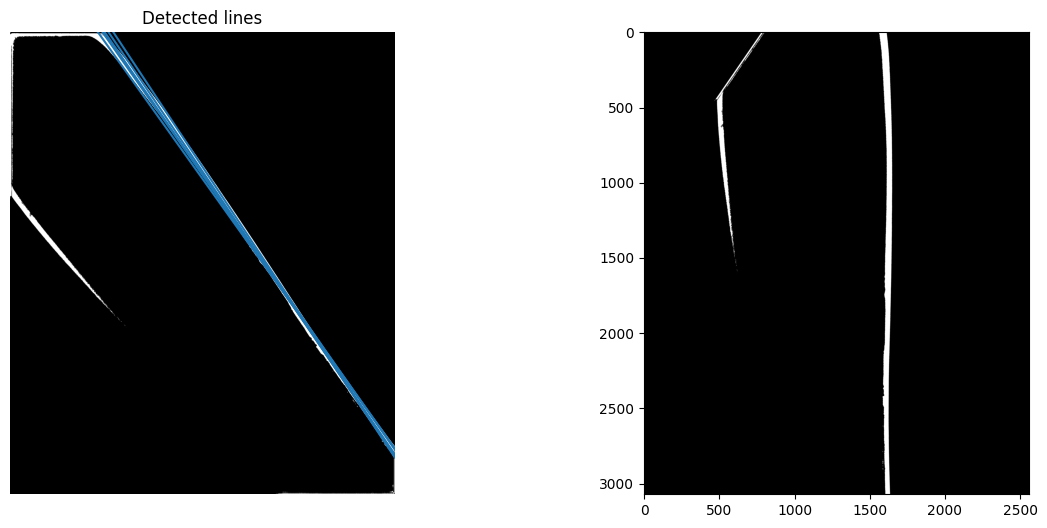

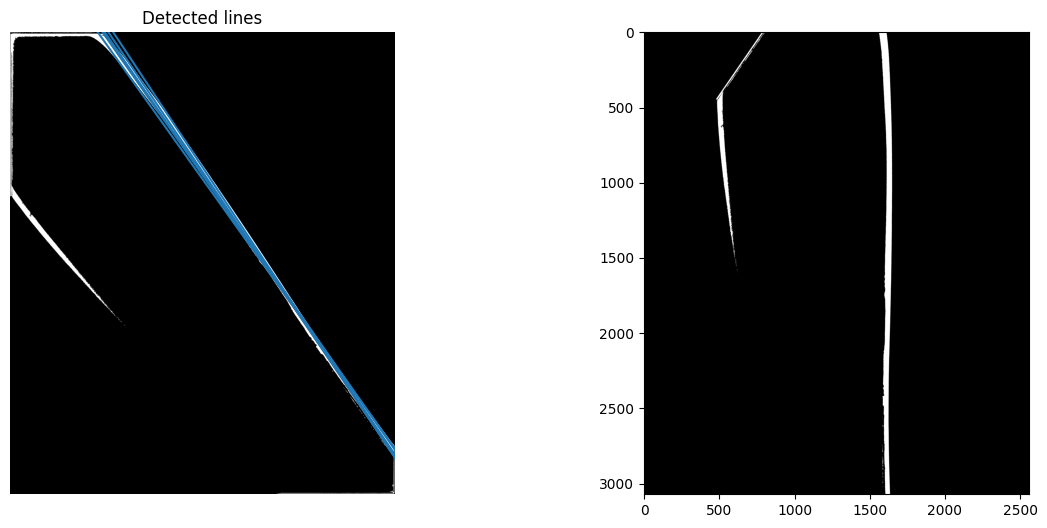

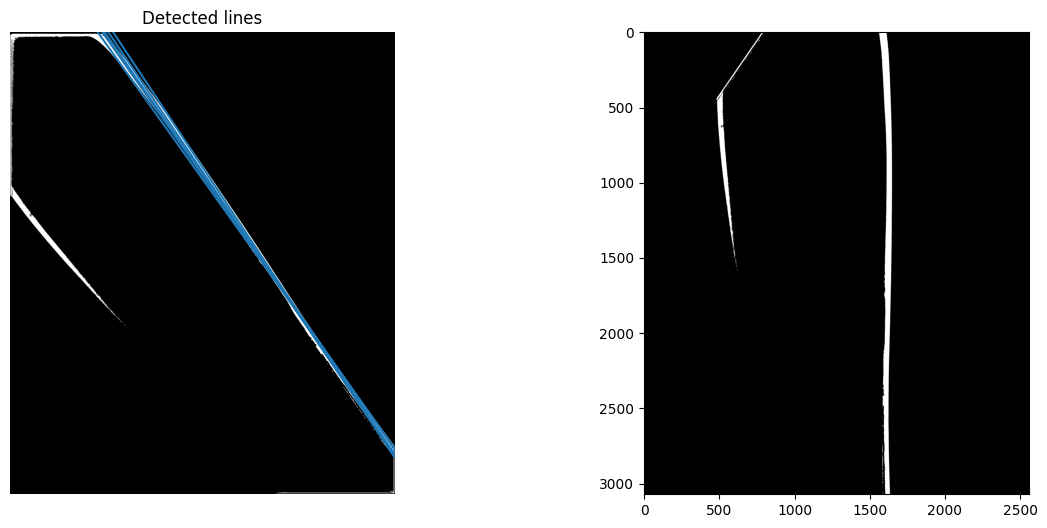

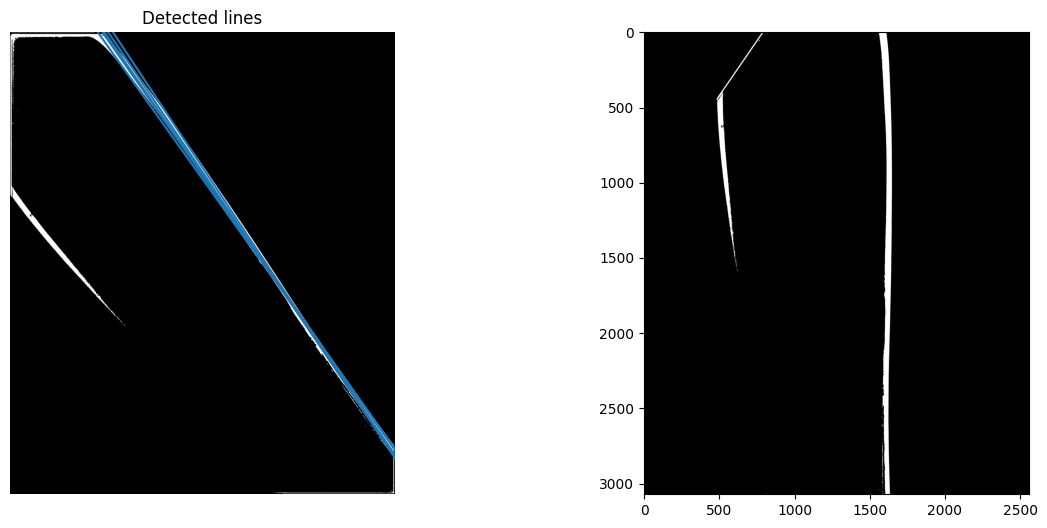

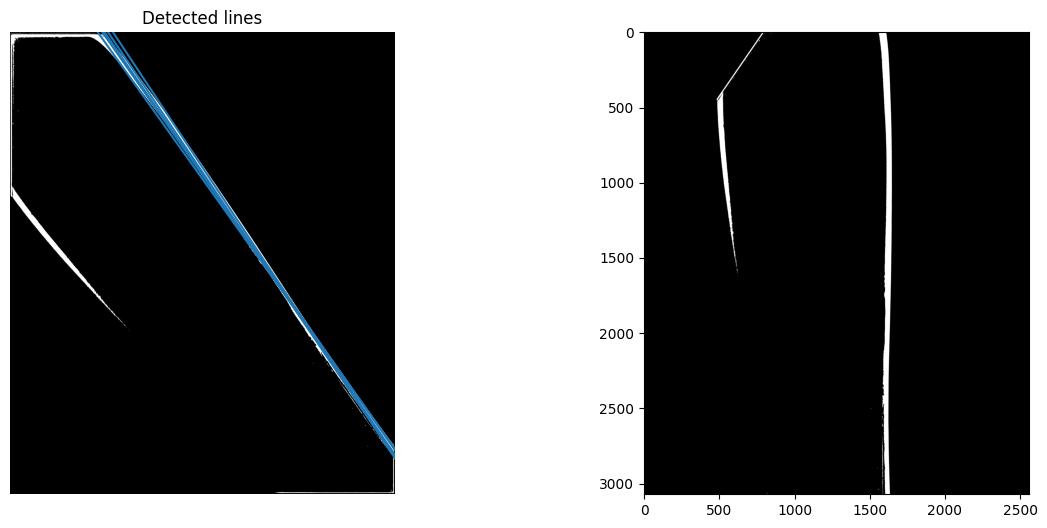

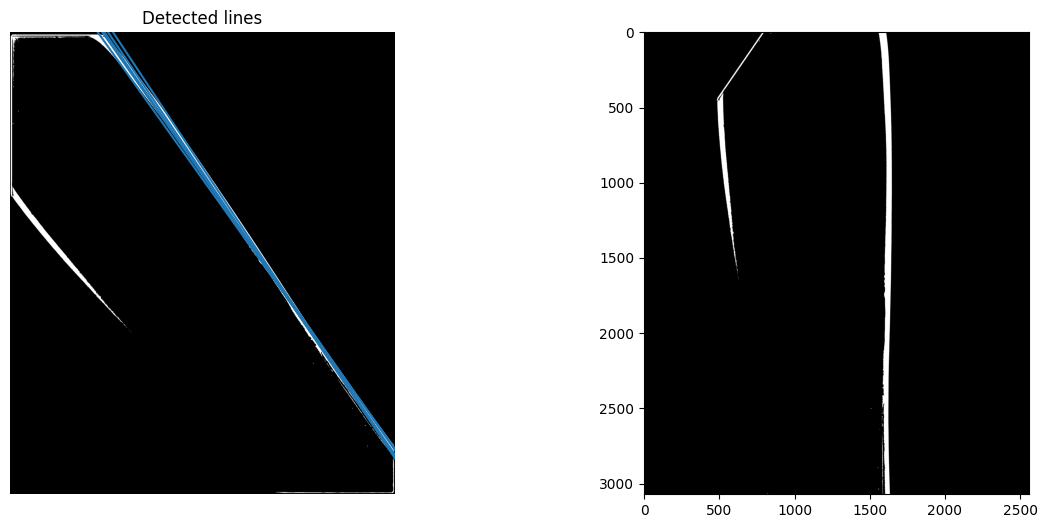

Error in callback <function flush_figures at 0x000001AFEBFE2660> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [20]:
# PERFORM OTSU THRESHOLDING; USE HOUGH TO FIND DOMINANT ANGLES OF IMAGES

# function returns an array of names files in a specific directory that will be analysed/altered
def toAnalyseArray(path, looking_for):
    images = Path(path)
    dir_list = os.listdir(images)

    to_analyse = []

    for item in dir_list:
        if bool(re.findall(looking_for, item)):
            to_analyse.append(item)

    # sorting into number order
    to_analyse = natsorted(to_analyse, key=lambda y: y.lower())
    return to_analyse


# using hough transform to find the dominant angles in an image, all these angles are added to a global array
# later, the median of this global array is found (see next fn) and all images are rotated by this median angle
def hough(img):
    global all_angles
    # Classic straight-line Hough transform
    # Set a precision of 0.5 degree.
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img, theta=tested_angles)

    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        all_angles.append(angle*180/np.pi)
    

all_angles = []
imgpath = 'C:\\Adaptix\\DowtyPrismBlade2ndHalf\\FilteredDowtyPrismBlade2ndHalf0007.tif'
#to_analyse = toAnalyseArray(path, 'Filtered')
#for item in to_analyse: 
  #  print('item ', item)  
 #   imgpath = path + str(item)
image = mpimg.imread(imgpath)#[:,:,0]

# otsu thresholding
threshold, img_out = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)  #cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY+ cv2.THRESH_OTSU

    # some recon images appear black so we need to do an automatic brightness/contrast adjustment...
    
#    if img_out is not None: # some arrays have all 0s so can't do .max() of that array, hence first check that not all values are 0
#seed = np.copy(img_out)  # seed image and mask image represent the maximum and minimum possible values of the reconstructed image
#seed[1:-1, 1:-1] = img_out.max()
#mask = img_out
# fill holes (i.e. isolated, dark spots) using erosion 
#eroded = reconstruction(seed, mask, method='erosion')  # neighbouring high intensity (white) values are replaced by low-intesity (blavk) values;
#eroded = img_out
# do hough transform before finding the dimensions
# hough(eroded)

# save image from the array `img_out' (stored in the form of a numbered array)
save_path = 'C:\\Adaptix\\DowtyPrismBlade2ndHalf\\OtsuFilteredDowtyPrismBlade2ndHalf0007.tif'# path + r'\\Otsu_'+ item 
i = Image.fromarray(img_out) 
i.save(save_path)






In [ ]:
# USE ANGLES FOUND PREVIOUSLY TO DECIDE ROTATION ANGLE; ROTATE THE IMAGE BY THIS ANGLE

# function returns an array of names files in a specific directory that will be analysed/altered
def toAnalyseArray(path, looking_for):
    images = Path(path)
    dir_list = os.listdir(images)

    to_analyse = []

    for item in dir_list:
        if bool(re.findall(looking_for, item)):
            to_analyse.append(item)

    # sorting into number order
    to_analyse = natsorted(to_analyse, key=lambda y: y.lower())
    return to_analyse


# rotating the image
def rotate(img, angle):
# rotate the image
    height, width = img.shape
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)  # anticlockwise rotation
    print('matrix found')
    rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
    print('rotated')
    print(rotated_image.shape)
    return rotated_image


path = 'C:\\Adaptix\\DowtyPrismBlade2ndHalf\\'
to_analyse = toAnalyseArray(path, 'Otsu')
print(*(np.sort(all_angles)))

# LOST AS TO HOW TO GET THE BEST ANGLE!!! tried mean, median, mode, range/2  
# angle = np.mean(np.sort(all_angles))  # median angle
# angle = np.median(np.sort(all_angles))  # median angle
# angle = scipy.stats.mode(all_angles)  # most frequent angle
angle = (np.min(all_angles) + np.max(all_angles))/2 # angle halfway i.e., min value + range/2

print('angle is ', angle)


for item in to_analyse:
    imgpath = path + str(item)
    image = mpimg.imread(imgpath)#[:,:,0]
    #if image is not None:
    rotated = rotate(image, angle)
    save_path = path + r'\\Rotated'+ item 
    i = Image.fromarray(rotated) 
    i.save(save_path)

In [23]:
# FIND THE DIMENSIONS OF THE OBJECT (USING BINARY ADDITION); CROP EACH OF THE SLICES BY  THESE DIMENSIONS

def toAnalyseArray(path, looking_for):
    images = Path(path)
    dir_list = os.listdir(images)
    to_analyse = []
    for item in dir_list:
        if bool(re.findall(looking_for, item)):
            to_analyse.append(item)
    # sorting into number order
    to_analyse = natsorted(to_analyse, key=lambda y: y.lower())
    return to_analyse


# for one slice, we have added all the rows with OR
def findDimensionsOr(img):
    rowOr = np.zeros(len(img[0]))
    for row in img:
        rowOr = np.logical_or(rowOr, row)
    return(rowOr)


def removeAnomoly1s(array):
    array = np.sort(array)
    
    mean = np.mean(array)
    std = np.std(array)
    
    median = np.median(array)
    range = np.max(array) - np.min(array)
    
    lower = median - 2*std
    upper = median + 2*std
    # lower = median - range/2 # 
    # upper = median + range/2 # 
    
    return np.rint(np.clip(array, lower, upper))  # round to nearest integer as mean/std are floats





# folder we want to be in
lookingfor = 'RotatedOtsu_'
to_analyse = toAnalyseArray(r'C:\\Adaptix\\DowtyPrismBlade2ndHalf\\', lookingfor)






added_rows_matx = []
added_cols_matx = []

for item in to_analyse: 
    imgpath = path + str(item)
    # Read Images
    img = mpimg.imread(imgpath)
    img = np.array(img)
    added_rows_matx.append(findDimensionsOr(img))  #[:,:,0]
    added_cols_matx.append(findDimensionsOr(img.T))  #[:,:,0]
# print(added_rows_all)
#added_rows_matx = np.array(added_rows_all)
#print(added_rows_all.shape)

added_rows_arry = findDimensionsOr(added_rows_matx)
added_cols_arry = findDimensionsOr(added_cols_matx)

# finding indicies of values in teh array which are nonzero
# apply removeAonomoly1a so you only keep the values which are 3/2/1 standard deviations of the mean index value
nonzero_idx_rows = removeAnomoly1s(np.array(np.nonzero(added_rows_arry)))
nonzero_idx_cols = removeAnomoly1s(np.array(np.nonzero(added_cols_arry)))



#print(f'min/max pixels {nonzero_idx_rows.min()}, {nonzero_idx_rows.max()}; min/max measured vals horizontally {nonzero_idx_rows.min()*0.14}mm, {nonzero_idx_rows.max()*0.14}mm; object width {np.abs(nonzero_idx_rows.min()*0.14 - nonzero_idx_rows.max()*0.14)}mm')
#print(f'min/max pixels {nonzero_idx_cols.min()}, {nonzero_idx_cols.max()}; min/max measured vals vertically {nonzero_idx_cols.min()*0.14}mm, {nonzero_idx_cols.max()*0.14}mm; object height {np.abs(nonzero_idx_cols.min()*0.14 - nonzero_idx_cols.max()*0.14)}mm')




# crop each slice using array slicing

for item in to_analyse: 
    imgpath = path + str(item)
    print(item)
    # Read Images
    img = mpimg.imread(imgpath)#[:,:,0]
    img = np.array(img)
    
    
    # cropped = img[nonzero_idx_rows.min():nonzero_idx_rows.max(), nonzero_idx_cols.min():nonzero_idx_cols.max()] 
    cropped = img[int(nonzero_idx_cols.min()):int(nonzero_idx_cols.max()), int(nonzero_idx_rows.min()):int(nonzero_idx_rows.max())] 
    save_path = path + r'\\Cropped'+ item 
    i = Image.fromarray(cropped)  # 
    i.save(save_path)
        
    

['1.tiff', '10.tiff', '11.tiff', '12.tiff', '13.tiff', '14.tiff', '15.tiff', '16.tiff', '17.tiff', '18.tiff', '19.tiff', '2.tiff', '20.tiff', '21.tiff', '22.tiff', '23.tiff', '24.tiff', '25.tiff', '26.tiff', '27.tiff', '28.tiff', '29.tiff', '3.tiff', '30.tiff', '31.tiff', '32.tiff', '33.tiff', '34.tiff', '35.tiff', '36.tiff', '37.tiff', '38.tiff', '39.tiff', '4.tiff', '40.tiff', '41.tiff', '42.tiff', '43.tiff', '44.tiff', '45.tiff', '46.tiff', '47.tiff', '48.tiff', '49.tiff', '5.tiff', '50.tiff', '51.tiff', '52.tiff', '53.tiff', '54.tiff', '55.tiff', '56.tiff', '57.tiff', '58.tiff', '59.tiff', '6.tiff', '60.tiff', '61.tiff', '62.tiff', '63.tiff', '64.tiff', '65.tiff', '66.tiff', '67.tiff', '68.tiff', '69.tiff', '7.tiff', '70.tiff', '71.tiff', '72.tiff', '73.tiff', '74.tiff', '75.tiff', '76.tiff', '77.tiff', '78.tiff', '79.tiff', '8.tiff', '80.tiff', '9.tiff', 'keys_file.txt', 'OtsuRotated_1.tiff', 'OtsuRotated_10.tiff', 'OtsuRotated_11.tiff', 'OtsuRotated_12.tiff', 'OtsuRotated_13.tiff

(3072, 2560)
average angle from the vertical -34.5
matrix found
rotated
(3072, 2560)


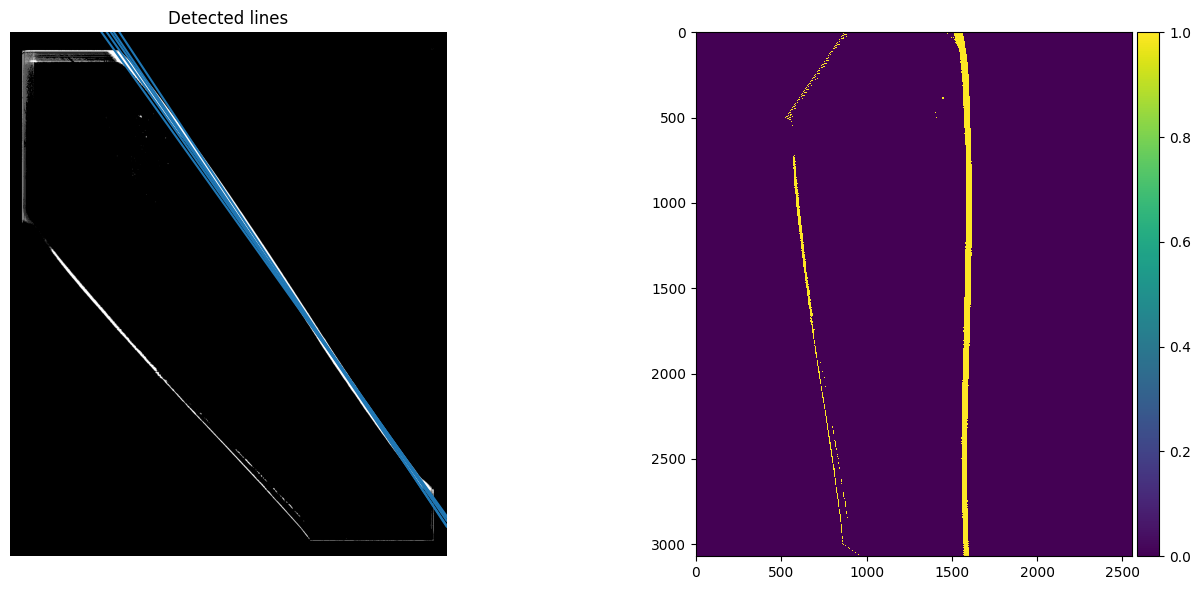

In [ ]:
# Hough transform to detect lines and the properties of the lines
# using some code from https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

import numpy as np
import imageio as iio
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import cv2
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm

imgpath = r"C:/Adaptix/2024-03-11/Recon/DowtyBlade_SolidNew/OtsuEroded_80.tiff"
# Read Images
img = mpimg.imread(imgpath)
img = np.array(img[:,:,0]) # only take the first face because all the faces are identical (checked with imshow)
print(img.shape)

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(img, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_ylim((img.shape[0], 0))
ax[0].set_axis_off()
ax[0].set_title('Detected lines')

# find angles of dominant lines
angles = []
distances = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    angles.append(angle*180/np.pi)
    distances.append(dist)
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[0].axline((x0, y0), slope=np.tan(angle + np.pi / 2))

mean_angle = np.mean(np.array(angles))
print(f'average angle from the vertical {mean_angle}')

# rotate the image
height, width = img.shape
center = (width/2, height/2)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=mean_angle, scale=1)  # anticlockwise rotation
print('matrix found')
rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
print('rotated')
print(rotated_image.shape)

# imshow(img[:,:,0])
imshow(rotated_image)
# then do the image processing to find the height


In [ ]:
# Take some slices and plot the 3D image

import numpy as np
import imageio as iio
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from skimage.io import imread, imshow
import cv2
from pathlib import Path
import os
import re
from natsort import natsorted 

def XnYvals(img):  # function to return x and y array for the coordinates where there is a 1 in the matrix
    xidx = []
    yidx = []
    for index, val in np.ndenumerate(img):
        if val == 1:
            xidx.append(index[0])
            yidx.append(index[1])
    return np.array(xidx), np.array(yidx)

# folder we want to be in
path = r'C:/Adaptix/2024-03-11/Recon/DowtyBlade_SolidNew/'

images = Path(path)
dir_list = os.listdir(images)

prefix = 'OtsuEroded'
to_analyse = []

for item in dir_list:
    if bool(re.findall(prefix, item)):
        to_analyse.append(item)

# sorting into number order
to_analyse = natsorted(to_analyse, key=lambda y: y.lower())

print(*to_analyse)

numimages = np.arange(0, 81, 5)

ax = plt.figure().add_subplot(projection = '3d')

for n in numimages:   
    # item = to_analyse[0]  # comment this out after testing
    item = to_analyse[n]
    imgpath = path + str(item)

    img = mpimg.imread(imgpath)
    img = np.array(img[:,:,0])
    print(img.shape)
    
    
    x, y = XnYvals(img)
    print('xshape ', x.shape)  # 3072
    print('yshape ', y.shape)  # 2560
    # ax.plot(x, y, n)
    ax.scatter(x,y,n)
 
plt.show()

#comment


In [19]:
# deleting files

# folder we want to be in
#path = r'C:\\Users\\ArzinaIsmaili\\OneDrive - Adaptix Limited\\Desktop\\deconvolution_adaptix2024\\HeightRecogCode\\DowtyPrismBlade2ndHalf\\'
path = r'C:\\Adaptix\\2024-03-11\\Recon\\DowtyBlade_SolidNew\\'
filled_images = Path(path)
dir_list = os.listdir(filled_images)

prefix = 'Cropped'
to_delete = []

for item in dir_list:
    if bool(re.findall(prefix, item)):
        to_delete.append(item)

for item in to_delete:
    #print(item)
    os.remove(path+str(item))